# 0. Import libraries & load files

In [ ]:
%matplotlib inline
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math as m
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import collections
import networkx as nx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/1USyd/3rd_sem/DATA5441/assignments/DATA5441_project7/data/residence_hall.csv/edges.csv')
print(data.columns)
print(data.shape)
data.head()

Index(['# source', ' target', ' weight'], dtype='object')
(2672, 3)


,# source,target,weight
0,0,1,3
1,0,2,4
2,0,3,3
3,0,4,3
4,0,5,4


# 1. Data Preparation for network to be analysed

## 1.1 Summing up weights

In [ ]:
df_summing_weight = data.groupby(['# source', ' target']).sum().reset_index()
print(df_summing_weight.shape)
df_summing_weight.head()

(2672, 3)


,# source,target,weight
0,0,1,3
1,0,2,4
2,0,3,3
3,0,4,3
4,0,5,4


## 1.2 Creating undirected network from data

In [ ]:
def pd_to_ud_networkx(df):
  '''
  Function to construct a graph from panda dataframe,
  By first creating a directed graph,
  then an undirected graph (keep only reciprocal edges),
  lastly update the weights so that mutual links have aggregated weights

  *Reference for weight-updating:
  https://stackoverflow.com/questions/56169907/networkx-change-weighted-directed-graph-to-undirected
  '''

  # first create a directed graph
  G0 = nx.DiGraph()
  for row in df.itertuples():
    source = row[1]
    target = row[2]
    value = row[3]
    G0.add_edge(source, target, weight = value)

  # create an undirected graph from graph above
  G = G0.to_undirected(reciprocal= True)

  # since networkx doesnt sum up weight for mutual links,
  # do it manually
  for node in G0:
    for ngbr in nx.neighbors(G0, node):
        if node in nx.neighbors(G0, ngbr):
            G.edges[node, ngbr]['weight'] = (
                G0.edges[node, ngbr]['weight'] + G0.edges[ngbr, node]['weight']
            )
  G.edges.data('weight')
  return G

In [ ]:
G = pd_to_ud_networkx(df_summing_weight)

In [ ]:
G.number_of_nodes()

217

In [ ]:
nx.number_connected_components(G)

4

In [ ]:
largest_cc = max(nx.connected_components(G), key=len)
Gc = G.subgraph(largest_cc)
Gc.number_of_nodes()

214

In [ ]:
print(list(nx.connected_components(G)))

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 189, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216}, {188}, {190}, {196}]


In [ ]:
G.remove_nodes_from([188,190,196])

In [ ]:
nx.number_connected_components(G)

1

## 1.3 For plotting on Gephi

In [ ]:
edge_btw = nx.edge_betweenness_centrality(G, k=None, normalized=True, weight="weight", seed=None)
nx.set_edge_attributes(G, edge_btw, "betweenness")

In [ ]:
edge_btw = nx.edge_betweenness_centrality(G, k=None, normalized=False, weight="weight", seed=None)
nx.set_edge_attributes(G, edge_btw, "betweenness_real")

In [ ]:
G[0][1]["betweenness"]

0.0038246091293346785

In [ ]:
nx.write_graphml_lxml(G, "residencehalledge.graphml")

# 2. Network

In [ ]:
G.number_of_nodes()

214

In [ ]:
G.number_of_edges()

833

In [ ]:
nx.transitivity(G)

0.2929639281305719

In [ ]:
nx.average_clustering(G)

0.34423205080488106

In [ ]:
nx.graph_number_of_cliques(G)

399

In [ ]:
nx.shortest_paths.average_shortest_path_length(G)

3.3919090869202755

In [ ]:
nx.diameter(G)

8

In [ ]:
nx.density(G)

0.036549515159492785

In [ ]:
def z_measures(G):
    '''Function to calc <z> and sigma_z'''
    N = G.number_of_nodes()
    zij= dict(nx.degree(G))
    zi = np.array([zij[k] for k in zij])
    average_z = np.sum(zi)/N
    av_zsquared = np.sum(np.square(zi))/N
    sd_z = np.sqrt(av_zsquared - np.square(average_z))

    return average_z, sd_z

In [ ]:
z_measures(G)

(7.785046728971962, 3.913857569276476)

In [ ]:
weight_dic  = nx.get_edge_attributes(G,'weight')

In [ ]:
weight_dic

{(0, 1): 7,
 (0, 2): 9,
 (0, 3): 7,
 (0, 4): 8,
 (0, 5): 7,
 (0, 6): 9,
 (0, 7): 8,
 (0, 8): 8,
 (1, 3): 9,
 (1, 4): 7,
 (1, 8): 6,
 (1, 9): 6,
 (1, 12): 7,
 (1, 42): 7,
 (1, 43): 6,
 (1, 45): 6,
 (1, 47): 7,
 (1, 48): 6,
 (1, 50): 6,
 (1, 52): 9,
 (2, 3): 6,
 (2, 8): 6,
 (2, 9): 8,
 (2, 13): 6,
 (2, 21): 7,
 (2, 26): 6,
 (2, 42): 7,
 (2, 44): 7,
 (2, 56): 6,
 (2, 96): 4,
 (2, 104): 6,
 (2, 112): 5,
 (2, 126): 6,
 (2, 127): 8,
 (3, 4): 7,
 (3, 10): 6,
 (3, 28): 9,
 (3, 42): 6,
 (3, 43): 6,
 (3, 47): 9,
 (3, 107): 7,
 (3, 131): 7,
 (4, 12): 7,
 (4, 13): 6,
 (4, 28): 6,
 (4, 42): 9,
 (4, 43): 10,
 (4, 104): 7,
 (5, 8): 10,
 (5, 48): 8,
 (5, 112): 4,
 (5, 116): 7,
 (6, 7): 8,
 (6, 13): 6,
 (6, 106): 7,
 (6, 112): 7,
 (6, 122): 8,
 (6, 139): 8,
 (7, 16): 7,
 (7, 27): 7,
 (7, 42): 7,
 (7, 106): 9,
 (8, 116): 6,
 (9, 10): 9,
 (9, 11): 9,
 (9, 12): 10,
 (9, 14): 8,
 (9, 16): 8,
 (9, 18): 8,
 (9, 19): 6,
 (9, 20): 7,
 (9, 21): 7,
 (9, 22): 8,
 (10, 22): 6,
 (10, 86): 6,
 (10, 87): 7,
 (11, 22)

In [ ]:
weight_list = np.array(list(weight_dic.values()))

In [ ]:
average_weight = np.average(weight_list)

In [ ]:
average_weight

7.206482593037215

In [ ]:
G.degree()

DegreeView({0: 8, 1: 13, 2: 15, 3: 11, 4: 9, 5: 5, 6: 7, 7: 6, 8: 5, 9: 12, 12: 8, 42: 7, 43: 8, 44: 7, 45: 10, 46: 10, 47: 6, 48: 4, 49: 11, 50: 9, 51: 12, 52: 9, 53: 10, 13: 12, 16: 15, 21: 6, 26: 13, 56: 9, 58: 11, 96: 2, 104: 6, 112: 11, 126: 8, 127: 8, 128: 8, 10: 6, 28: 4, 55: 7, 107: 9, 131: 5, 132: 6, 11: 7, 97: 4, 108: 7, 156: 6, 70: 14, 116: 6, 106: 7, 122: 5, 139: 5, 27: 10, 41: 4, 14: 6, 15: 5, 17: 4, 18: 6, 19: 4, 20: 7, 22: 10, 23: 9, 68: 9, 86: 13, 87: 9, 88: 7, 109: 10, 110: 11, 111: 10, 25: 6, 35: 12, 99: 8, 129: 6, 130: 9, 59: 6, 62: 10, 105: 4, 67: 4, 141: 4, 149: 14, 159: 4, 31: 4, 100: 4, 101: 7, 30: 6, 34: 6, 146: 10, 147: 8, 197: 2, 200: 5, 201: 7, 39: 7, 69: 24, 71: 8, 72: 18, 123: 6, 162: 10, 178: 9, 203: 3, 57: 8, 205: 8, 54: 9, 91: 14, 114: 10, 140: 12, 148: 7, 24: 4, 29: 1, 32: 7, 33: 4, 36: 3, 37: 6, 38: 5, 40: 17, 60: 13, 113: 3, 115: 9, 117: 3, 118: 3, 119: 12, 120: 11, 65: 8, 76: 9, 121: 2, 124: 9, 125: 11, 73: 14, 137: 9, 138: 16, 150: 12, 152: 5, 157: 

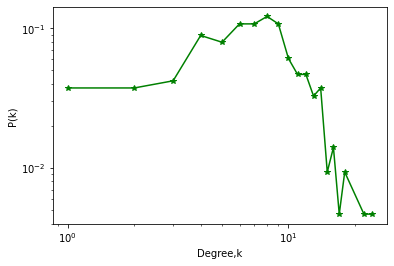

In [ ]:
degree_sequence = sorted([d for n, d in G.degree()],reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
prob_deg = cnt/np.sum(cnt)
plt.loglog(deg, prob_deg,'g*-')
plt.xlabel('Degree,k')
plt.ylabel('P(k)')
plt.savefig("p_k.png")
plt.show()

In [ ]:
weight_list.shape

(833,)

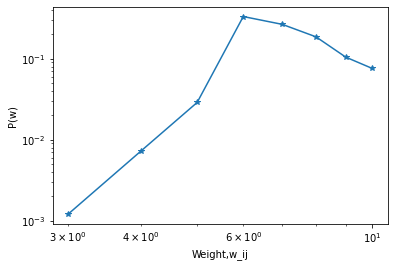

In [ ]:
weight_sequence = sorted(weight_list,reverse=True)
weightCount = collections.Counter(weight_sequence)
w, cnt = zip(*weightCount.items())
prob_w = cnt/np.sum(cnt)
plt.loglog(w, prob_w, '*-')
plt.xlabel('Weight,w_ij')
plt.ylabel('P(w)')
plt.savefig("p_w.png")
plt.show()

In [ ]:
nx.degree_histogram(G)/np.sum(nx.degree_histogram(G))

array([0.        , 0.03738318, 0.03738318, 0.04205607, 0.08878505,
       0.07943925, 0.10747664, 0.10747664, 0.12149533, 0.10747664,
       0.06074766, 0.04672897, 0.04672897, 0.03271028, 0.03738318,
       0.00934579, 0.01401869, 0.0046729 , 0.00934579, 0.        ,
       0.        , 0.        , 0.0046729 , 0.        , 0.0046729 ])

Text(0, 0.5, 'Probability, P(k)')

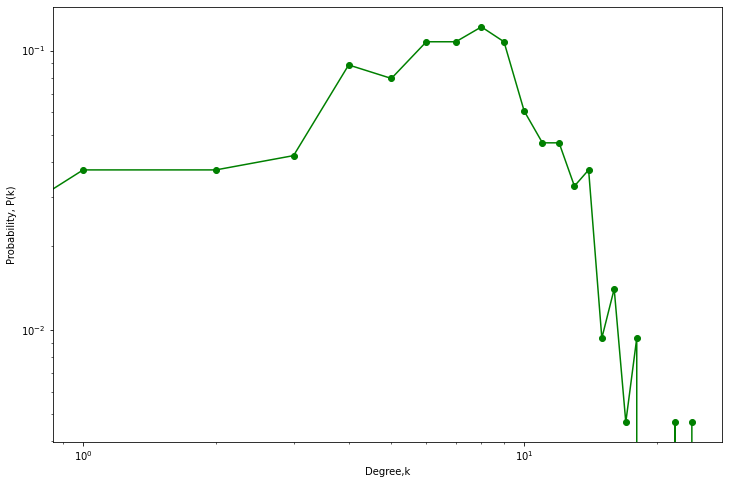

In [ ]:
degree_freq = nx.degree_histogram(G)
degrees = range(len(degree_freq))
prob_freq = degree_freq/np.sum(degree_freq)
plt.figure(figsize=(12, 8))
plt.loglog(degrees, prob_freq,'go-')
plt.xlabel('Degree,k')
plt.ylabel('Probability, P(k)')

In [ ]:
from itertools import count
def draw_colormap_degree(G, with_labels = True):
    '''Draw the graph with node's color varies with its degree'''
    # get unique groups
    groups = set([G.degree()[node] for node in list(G.nodes())])
    mapping = dict(zip(sorted(groups),count()))
    colors = [mapping[G.degree()[node]] for node in list(G.nodes())]
    widths = nx.get_edge_attributes(G, 'weight')

    # drawing nodes and edges separately so we can capture collection for colobar
    plt.figure(figsize=(20, 10))
    pos = nx.spring_layout(G)

    ec = nx.draw_networkx_edges(G, pos, edgelist = widths.keys(),\
                                width = list(widths.values()),\
                                edge_color='blue', alpha=0.4)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color=colors,\
                                node_size=500, cmap=plt.cm.RdPu_r)

    if with_labels == True:
        labels = nx.draw_networkx_labels(G,pos)

    plt.colorbar(nc)
    plt.axis('off')
    plt.savefig('residencehall_network.png', bbox_inches='tight')
    plt.show()

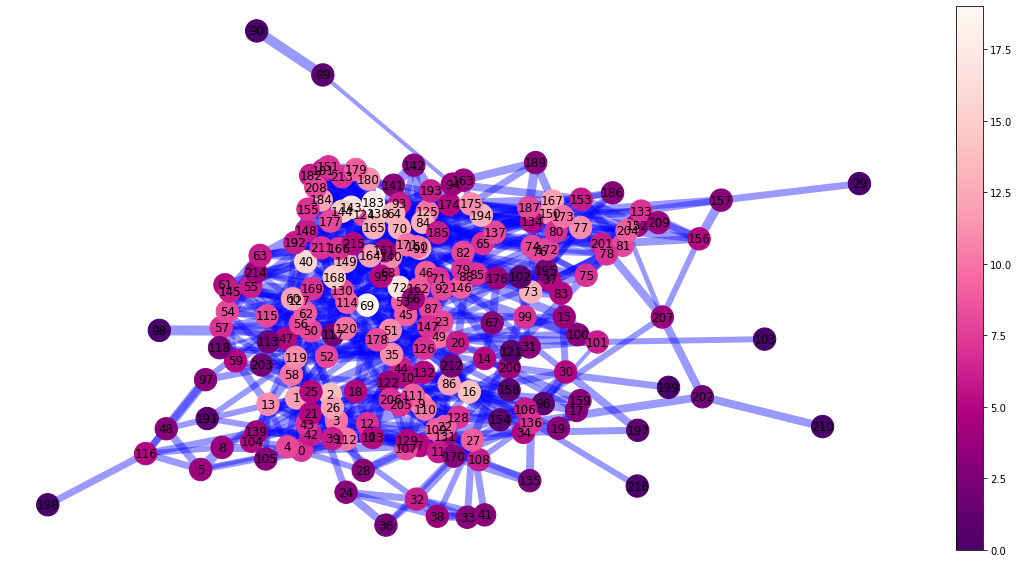

In [ ]:
draw_colormap_degree(G)

# 3. Result

## working with Weight

In [ ]:
def weight_dict(G):
  '''
  INPUT
  G:
  undirected nx graph

  RETURN
  w_dict:
  {weight1:[list of edges],weight2:[list of edges]}
  '''
  w_dict = {}
  for node1, node2, data in G.edges(data=True):
    edge = (node1,node2)
    w = data['weight']
    if w in w_dict:
      w_dict[w].append(edge)
    else:
      w_dict[w]= [edge]

  return w_dict

## working with Overlapping

In [ ]:
def overlap_dict(G):
  o_dict = {}
  for edge in G.edges():
    node1, node2 = edge
    n_ij = len(set(nx.common_neighbors(G, node1, node2)))
    n_joined = G.degree(node1) + G.degree(node2) - n_ij - 2

    if n_joined == 0:
      o_ij = 0
    else:
      o_ij = n_ij / n_joined

    if o_ij in o_dict:
      o_dict[o_ij].append(edge)
    else:
      o_dict[o_ij] = [edge]

  return o_dict

## Rgc(f) vs f and S vs f

### code fuctions

In [ ]:
def rgc_(G):
  '''to return the size of the largest component'''
  largest_cc = max(nx.connected_components(G),key=len)
  G_lcc = G.subgraph(largest_cc)
  rgc = G_lcc.number_of_nodes()/G.number_of_nodes()
  return rgc

In [ ]:
from collections import Counter

def suscept_(G):
  '''to return the susceptibility of graph
  S = sum(s<s_max)of n_s*s^2 / N
  n_s = number of components with size s
  '''
  s_list = [len(c) for c in sorted(nx.connected_components(G), key=len)]
  # remove the largest size, s_max
  s_list.pop()

  # to count each s occurrence
  s_dict = dict(Counter(s_list))

  sum_s = sum([s**2 * n_s for s, n_s in s_dict.items()])
  N = G.number_of_nodes()
  S = sum_s / N
  return S

In [ ]:
def remove_links_sequentially(sorted_list,G0):
  G = G0.copy()
  f = 0
  i = 0 # no. of link removed
  f_list = [0]
  rgc0 = rgc_(G)
  S0 = suscept_(G)
  Rgc_list = [rgc0]
  S_list = [S0]
  for edge in sorted_list:
    G.remove_edge(*edge)
    i += 1
    f = i/ (G0.number_of_edges())
    f_list.append(f)
    rgc = rgc_(G)
    S = suscept_(G)
    Rgc_list.append(rgc)
    S_list.append(S)

  return f_list, Rgc_list, S_list

In [ ]:
def measures(G,input_dict,order_removal):
  '''
  INPUT
  G:
  undirected nx graph

  input_dict:
  {weight1:[list of edge(s)],weight2:[list of edge]...} or
  {Oij1:[list of edge(s)],Oij2:[list of edge]...}

  order_removal:
  "ascending" - from smallest to bigest key in input_dict
  or
  "descending" - highest to smallest

  RETURN
  f_list - number of link/edge removed
  Rgc_list - relative largest component
  S_list - behaviour of susceptibility
  '''

  if order_removal == 'ascending':
    sorted_key = sorted(input_dict)
  elif order_removal == 'descending':
    sorted_key = sorted(input_dict, reverse=True)
  else:
    print('Order of removal should be "ascending" or "descending".')

  sorted_list= []
  for k in sorted_key:
    for edge in input_dict[k]:
      sorted_list.append(edge)
  f_list, Rgc_list, S_list = remove_links_sequentially(sorted_list,G)

  return f_list, Rgc_list, S_list

### plot with latex

In [ ]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

In [ ]:
def visualise(G):
  '''Plot the results'''
  # wasc = weight,ascending; wdes = weight, descending
  w_dict = weight_dict(G)
  f_list, Rgc_wasc, S_wasc = measures(G,w_dict,order_removal='ascending')
  f_list, Rgc_wdes, S_wdes = measures(G,w_dict,order_removal='descending')
  # oasc = overlap,ascending; odes = overlap, descending
  o_dict = overlap_dict(G)
  f_list, Rgc_oasc, S_oasc = measures(G,o_dict,order_removal='ascending')
  f_list, Rgc_odes, S_odes = measures(G,o_dict,order_removal='descending')

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10),\
                                               sharex= 'col')

  # top left
  ax1.set_title(r'\textit{$w_{ij}$ removal}')
  ax1.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax1.plot(f_list, Rgc_wasc, 'r-')
  ax1.plot(f_list, Rgc_wdes, 'k-')

  # top right
  ax2.set_title(r'\textit{$O_{ij}$ removal}')
  ax2.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax2.plot(f_list, Rgc_oasc, 'r-')
  ax2.plot(f_list, Rgc_odes, 'k-')

  # bottom left
  ax3.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax3.set_xlabel(r'\textit{$f$}')
  ax3.plot(f_list, S_wasc, 'r-')
  ax3.plot(f_list, S_wdes, 'k-')

  # top right
  ax4.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax4.set_xlabel(r'\textit{$f$}')
  ax4.plot(f_list, S_oasc, 'r-')
  ax4.plot(f_list, S_odes, 'k-')


  red = mpatches.Patch(color='r', label='Ascending order')
  black = mpatches.Patch(color='k', label='Descending order')
  fig.legend(handles=[red, black], bbox_to_anchor=(0.98, 0.96),loc="upper right")
  fig.suptitle(r'\textit{ANU Residence Hall network}', x = 0.52, y = 1,fontsize=14)
  fig.tight_layout()
  plt.savefig('residence.png', bbox_inches='tight')
  plt.show()


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


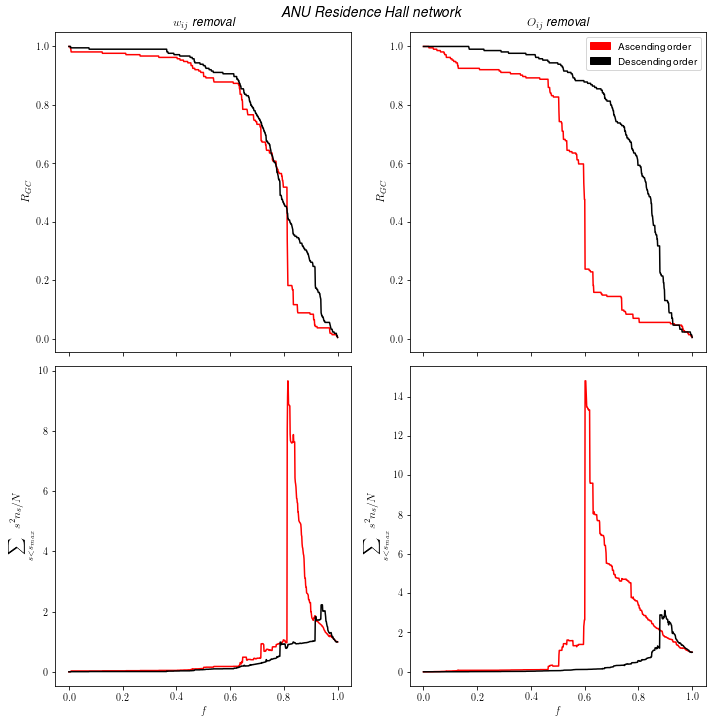

In [ ]:
visualise(G)

## Experiment - Shuffle weights

In [ ]:
def weight_shuffling(G,p):
  '''
  INPUT
  G: nx graph
  p: a proportion, should be a number (float/integer)

  RETURN
  Gw: a nx graph with proportion p of the all edges
      been shuffled for their weights

  *Modified from Jimena's code, original idea by Jimena
  '''
  Gw = G.copy()
  L = Gw.number_of_edges()
  # Since we are swapping two edges
  # L/2 will be the possible max
  # total shuffles = p*L/2, whole number
  total_shuffles = int(p*L/2)
  edge_list = list(G.edges())
  w_dict = dict(nx.get_edge_attributes(Gw, 'weight'))
  for shuffle in range(total_shuffles):
          # randomly sample 2 edges
          edge1, edge2 = random.sample(edge_list, 2)
          # get their wieght
          w1 = w_dict[edge1]
          w2 = w_dict[edge2]
          #swap their weight
          Gw.edges[edge1]['weight']= w2
          Gw.edges[edge2]['weight']= w1

  return Gw

In [ ]:
# interested ps
# p = [0.3, 0.5, 5]

### p = 0.3

In [ ]:
Gw1 = weight_shuffling(G,0.3)

In [ ]:
def visualise1(G):
  '''Plot the results'''
  # wasc = weight,ascending; wdes = weight, descending
  w_dict = weight_dict(G)
  f_list, Rgc_wasc, S_wasc = measures(G,w_dict,order_removal='ascending')
  f_list, Rgc_wdes, S_wdes = measures(G,w_dict,order_removal='descending')
  # oasc = overlap,ascending; odes = overlap, descending
  o_dict = overlap_dict(G)
  f_list, Rgc_oasc, S_oasc = measures(G,o_dict,order_removal='ascending')
  f_list, Rgc_odes, S_odes = measures(G,o_dict,order_removal='descending')

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10),\
                                               sharex= 'col')

  # top left
  ax1.set_title(r'\textit{$w_{ij}$ removal}')
  ax1.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax1.plot(f_list, Rgc_wasc, 'r-')
  ax1.plot(f_list, Rgc_wdes, 'k-')

  # top right
  ax2.set_title(r'\textit{$O_{ij}$ removal}')
  ax2.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax2.plot(f_list, Rgc_oasc, 'r-')
  ax2.plot(f_list, Rgc_odes, 'k-')

  # bottom left
  ax3.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax3.set_xlabel(r'\textit{$f$}')
  ax3.plot(f_list, S_wasc, 'r-')
  ax3.plot(f_list, S_wdes, 'k-')

  # top right
  ax4.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax4.set_xlabel(r'\textit{$f$}')
  ax4.plot(f_list, S_oasc, 'r-')
  ax4.plot(f_list, S_odes, 'k-')


  red = mpatches.Patch(color='r', label='Ascending order')
  black = mpatches.Patch(color='k', label='Descending order')
  fig.legend(handles=[red, black], bbox_to_anchor=(0.98, 0.96),loc="upper right")
  fig.suptitle(r'\textit{ANU Residence Hall network, shuffled weight by p=0.3}', x = 0.52, y = 1,fontsize=14)
  fig.tight_layout()
  plt.savefig('residence_w1.png', bbox_inches='tight')
  plt.show()

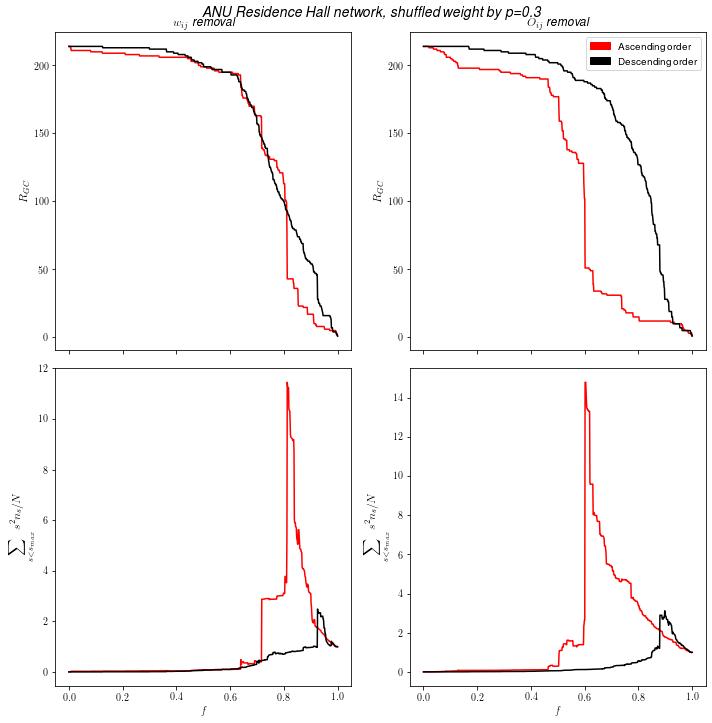

In [ ]:
visualise1(Gw1)

### p=0.5

In [ ]:
Gw2 = weight_shuffling(G,0.5)

In [ ]:
def visualise2(G):
  '''Plot the results'''
  # wasc = weight,ascending; wdes = weight, descending
  w_dict = weight_dict(G)
  f_list, Rgc_wasc, S_wasc = measures(G,w_dict,order_removal='ascending')
  f_list, Rgc_wdes, S_wdes = measures(G,w_dict,order_removal='descending')
  # oasc = overlap,ascending; odes = overlap, descending
  o_dict = overlap_dict(G)
  f_list, Rgc_oasc, S_oasc = measures(G,o_dict,order_removal='ascending')
  f_list, Rgc_odes, S_odes = measures(G,o_dict,order_removal='descending')

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10),\
                                               sharex= 'col')

  # top left
  ax1.set_title(r'\textit{$w_{ij}$ removal}')
  ax1.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax1.plot(f_list, Rgc_wasc, 'r-')
  ax1.plot(f_list, Rgc_wdes, 'k-')

  # top right
  ax2.set_title(r'\textit{$O_{ij}$ removal}')
  ax2.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax2.plot(f_list, Rgc_oasc, 'r-')
  ax2.plot(f_list, Rgc_odes, 'k-')

  # bottom left
  ax3.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax3.set_xlabel(r'\textit{$f$}')
  ax3.plot(f_list, S_wasc, 'r-')
  ax3.plot(f_list, S_wdes, 'k-')

  # top right
  ax4.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax4.set_xlabel(r'\textit{$f$}')
  ax4.plot(f_list, S_oasc, 'r-')
  ax4.plot(f_list, S_odes, 'k-')


  red = mpatches.Patch(color='r', label='Ascending order')
  black = mpatches.Patch(color='k', label='Descending order')
  fig.legend(handles=[red, black], bbox_to_anchor=(0.98, 0.96),loc="upper right")
  fig.suptitle(r'\textit{ANU Residence Hall network, shuffled weight by p=0.5}', x = 0.52, y = 1,fontsize=14)
  fig.tight_layout()
  plt.savefig('residence_w2.png', bbox_inches='tight')
  plt.show()

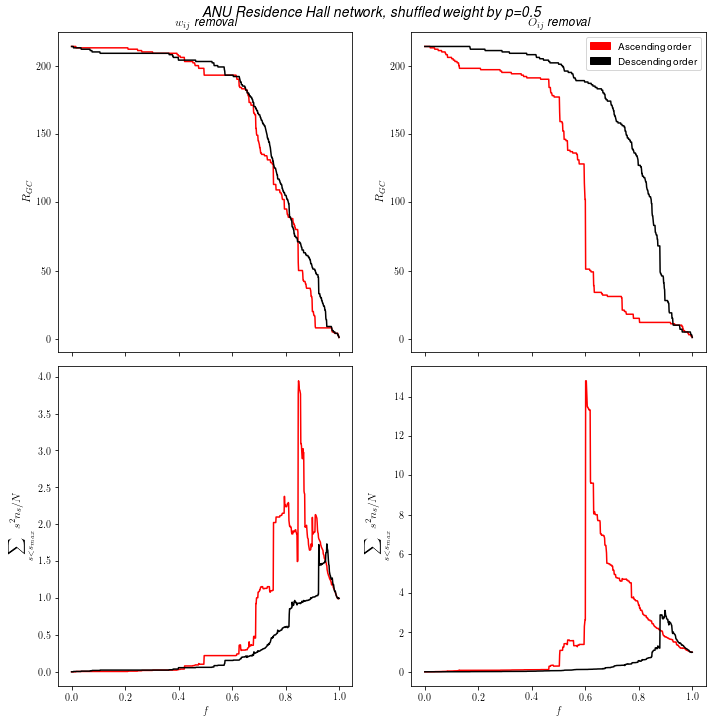

In [ ]:
visualise2(Gw2)

### p=5

In [ ]:
Gw3 = weight_shuffling(G,5)

In [ ]:
def visualise3(G):
  '''Plot the results'''
  # wasc = weight,ascending; wdes = weight, descending
  w_dict = weight_dict(G)
  f_list, Rgc_wasc, S_wasc = measures(G,w_dict,order_removal='ascending')
  f_list, Rgc_wdes, S_wdes = measures(G,w_dict,order_removal='descending')
  # oasc = overlap,ascending; odes = overlap, descending
  o_dict = overlap_dict(G)
  f_list, Rgc_oasc, S_oasc = measures(G,o_dict,order_removal='ascending')
  f_list, Rgc_odes, S_odes = measures(G,o_dict,order_removal='descending')

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10),\
                                               sharex= 'col')

  # top left
  ax1.set_title(r'\textit{$w_{ij}$ removal}')
  ax1.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax1.plot(f_list, Rgc_wasc, 'r-')
  ax1.plot(f_list, Rgc_wdes, 'k-')

  # top right
  ax2.set_title(r'\textit{$O_{ij}$ removal}')
  ax2.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax2.plot(f_list, Rgc_oasc, 'r-')
  ax2.plot(f_list, Rgc_odes, 'k-')

  # bottom left
  ax3.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax3.set_xlabel(r'\textit{$f$}')
  ax3.plot(f_list, S_wasc, 'r-')
  ax3.plot(f_list, S_wdes, 'k-')

  # top right
  ax4.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax4.set_xlabel(r'\textit{$f$}')
  ax4.plot(f_list, S_oasc, 'r-')
  ax4.plot(f_list, S_odes, 'k-')


  red = mpatches.Patch(color='r', label='Ascending order')
  black = mpatches.Patch(color='k', label='Descending order')
  fig.legend(handles=[red, black], bbox_to_anchor=(0.98, 0.96),loc="upper right")
  fig.suptitle(r'\textit{ANU Residence Hall network, shuffled weight by p=5}', x = 0.52, y = 1,fontsize=14)
  fig.tight_layout()
  plt.savefig('residence_w3.png', bbox_inches='tight')
  plt.show()

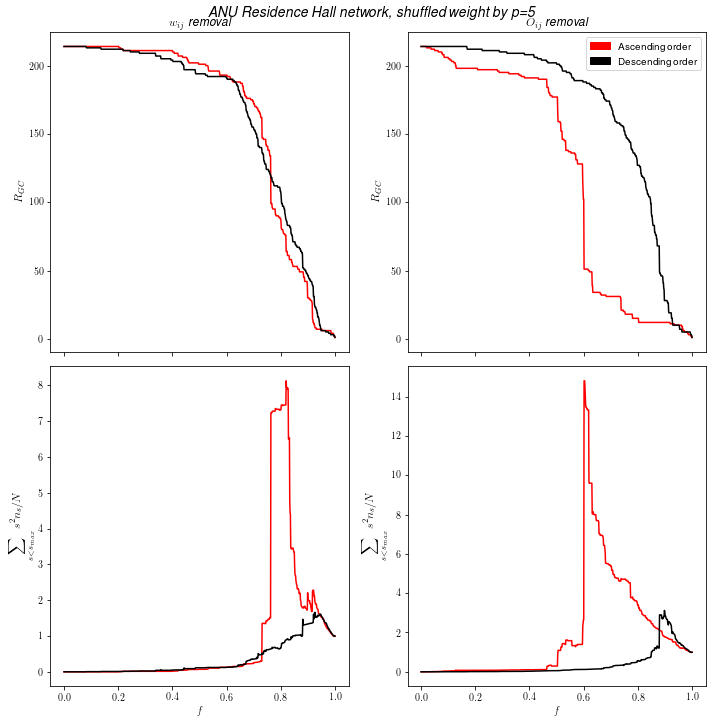

In [ ]:
visualise3(Gw3)

### p=1

In [ ]:
Gw4 = weight_shuffling(G,1)

In [ ]:
def visualise4(G):
  '''Plot the results'''
  # wasc = weight,ascending; wdes = weight, descending
  w_dict = weight_dict(G)
  f_list, Rgc_wasc, S_wasc = measures(G,w_dict,order_removal='ascending')
  f_list, Rgc_wdes, S_wdes = measures(G,w_dict,order_removal='descending')
  # oasc = overlap,ascending; odes = overlap, descending
  o_dict = overlap_dict(G)
  f_list, Rgc_oasc, S_oasc = measures(G,o_dict,order_removal='ascending')
  f_list, Rgc_odes, S_odes = measures(G,o_dict,order_removal='descending')

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10),\
                                               sharex= 'col')

  # top left
  ax1.set_title(r'\textit{$w_{ij}$ removal}')
  ax1.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax1.plot(f_list, Rgc_wasc, 'r-')
  ax1.plot(f_list, Rgc_wdes, 'k-')

  # top right
  ax2.set_title(r'\textit{$O_{ij}$ removal}')
  ax2.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax2.plot(f_list, Rgc_oasc, 'r-')
  ax2.plot(f_list, Rgc_odes, 'k-')

  # bottom left
  ax3.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax3.set_xlabel(r'\textit{$f$}')
  ax3.plot(f_list, S_wasc, 'r-')
  ax3.plot(f_list, S_wdes, 'k-')

  # top right
  ax4.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax4.set_xlabel(r'\textit{$f$}')
  ax4.plot(f_list, S_oasc, 'r-')
  ax4.plot(f_list, S_odes, 'k-')


  red = mpatches.Patch(color='r', label='Ascending order')
  black = mpatches.Patch(color='k', label='Descending order')
  fig.legend(handles=[red, black], bbox_to_anchor=(0.98, 0.96),loc="upper right")
  fig.suptitle(r'\textit{ANU Residence Hall network, shuffled weight by p=1}', x = 0.52, y = 1,fontsize=14)
  fig.tight_layout()
  plt.savefig('residence_w4.png', bbox_inches='tight')
  plt.show()

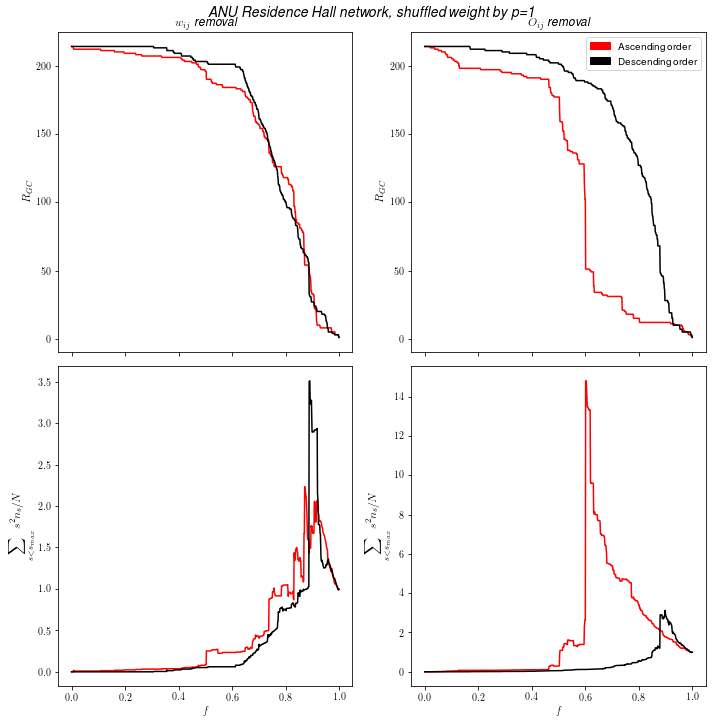

In [ ]:
visualise4(Gw4)

### p=10

In [ ]:
Gw5 = weight_shuffling(G,10)

In [ ]:
def visualise5(G):
  '''Plot the results'''
  # wasc = weight,ascending; wdes = weight, descending
  w_dict = weight_dict(G)
  f_list, Rgc_wasc, S_wasc = measures(G,w_dict,order_removal='ascending')
  f_list, Rgc_wdes, S_wdes = measures(G,w_dict,order_removal='descending')
  # oasc = overlap,ascending; odes = overlap, descending
  o_dict = overlap_dict(G)
  f_list, Rgc_oasc, S_oasc = measures(G,o_dict,order_removal='ascending')
  f_list, Rgc_odes, S_odes = measures(G,o_dict,order_removal='descending')

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10),\
                                               sharex= 'col')

  # top left
  ax1.set_title(r'\textit{$w_{ij}$ removal}')
  ax1.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax1.plot(f_list, Rgc_wasc, 'r-')
  ax1.plot(f_list, Rgc_wdes, 'k-')

  # top right
  ax2.set_title(r'\textit{$O_{ij}$ removal}')
  ax2.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax2.plot(f_list, Rgc_oasc, 'r-')
  ax2.plot(f_list, Rgc_odes, 'k-')

  # bottom left
  ax3.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax3.set_xlabel(r'\textit{$f$}')
  ax3.plot(f_list, S_wasc, 'r-')
  ax3.plot(f_list, S_wdes, 'k-')

  # top right
  ax4.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax4.set_xlabel(r'\textit{$f$}')
  ax4.plot(f_list, S_oasc, 'r-')
  ax4.plot(f_list, S_odes, 'k-')


  red = mpatches.Patch(color='r', label='Ascending order')
  black = mpatches.Patch(color='k', label='Descending order')
  fig.legend(handles=[red, black], bbox_to_anchor=(0.98, 0.96),loc="upper right")
  fig.suptitle(r'\textit{ANU Residence Hall network, shuffled weight by p=10}', x = 0.52, y = 1,fontsize=14)
  fig.tight_layout()
  plt.savefig('residence_w5.png', bbox_inches='tight')
  plt.show()

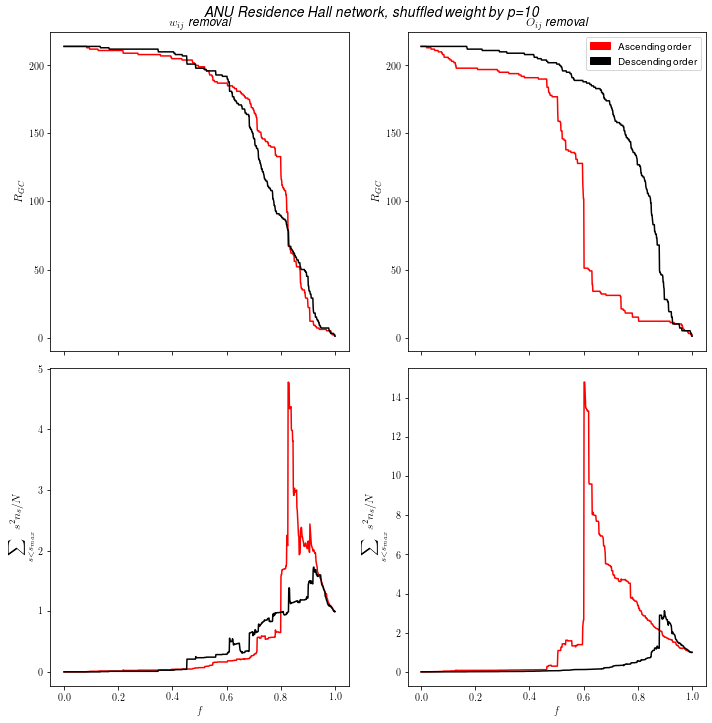

In [ ]:
visualise5(Gw5)

### p=50

In [ ]:
Gw6 = weight_shuffling(G,50)

In [ ]:
def visualise6(G):
  '''Plot the results'''
  # wasc = weight,ascending; wdes = weight, descending
  w_dict = weight_dict(G)
  f_list, Rgc_wasc, S_wasc = measures(G,w_dict,order_removal='ascending')
  f_list, Rgc_wdes, S_wdes = measures(G,w_dict,order_removal='descending')
  # oasc = overlap,ascending; odes = overlap, descending
  o_dict = overlap_dict(G)
  f_list, Rgc_oasc, S_oasc = measures(G,o_dict,order_removal='ascending')
  f_list, Rgc_odes, S_odes = measures(G,o_dict,order_removal='descending')

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10),\
                                               sharex= 'col')

  # top left
  ax1.set_title(r'\textit{$w_{ij}$ removal}')
  ax1.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax1.plot(f_list, Rgc_wasc, 'r-')
  ax1.plot(f_list, Rgc_wdes, 'k-')

  # top right
  ax2.set_title(r'\textit{$O_{ij}$ removal}')
  ax2.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax2.plot(f_list, Rgc_oasc, 'r-')
  ax2.plot(f_list, Rgc_odes, 'k-')

  # bottom left
  ax3.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax3.set_xlabel(r'\textit{$f$}')
  ax3.plot(f_list, S_wasc, 'r-')
  ax3.plot(f_list, S_wdes, 'k-')

  # top right
  ax4.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax4.set_xlabel(r'\textit{$f$}')
  ax4.plot(f_list, S_oasc, 'r-')
  ax4.plot(f_list, S_odes, 'k-')


  red = mpatches.Patch(color='r', label='Ascending order')
  black = mpatches.Patch(color='k', label='Descending order')
  fig.legend(handles=[red, black], bbox_to_anchor=(0.98, 0.96),loc="upper right")
  fig.suptitle(r'\textit{ANU Residence Hall network, shuffled weight by p=50}', x = 0.52, y = 1,fontsize=14)
  fig.tight_layout()
  plt.savefig('residence_w6.png', bbox_inches='tight')
  plt.show()

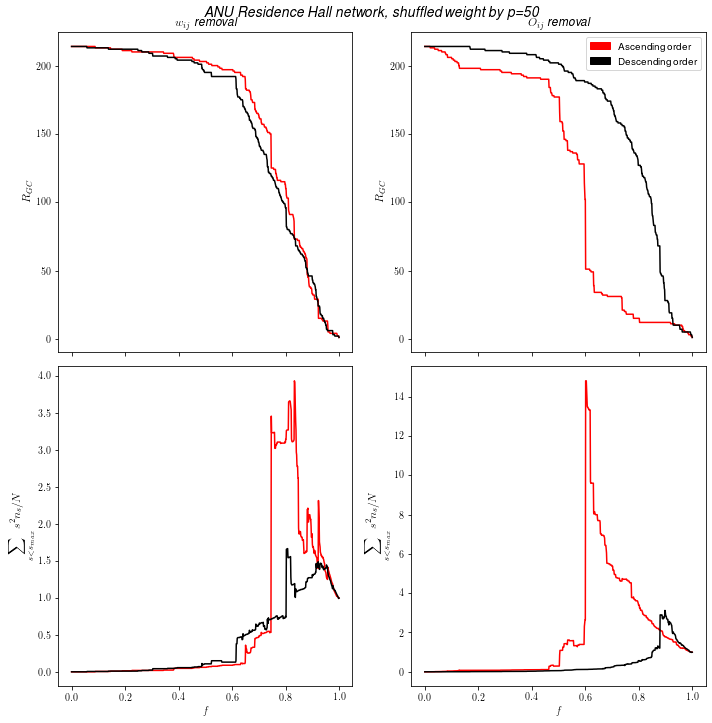

In [ ]:
visualise6(Gw6)

### p=100

In [ ]:
Gw7 = weight_shuffling(G,100)

In [ ]:
def visualise7(G):
  '''Plot the results'''
  # wasc = weight,ascending; wdes = weight, descending
  w_dict = weight_dict(G)
  f_list, Rgc_wasc, S_wasc = measures(G,w_dict,order_removal='ascending')
  f_list, Rgc_wdes, S_wdes = measures(G,w_dict,order_removal='descending')
  # oasc = overlap,ascending; odes = overlap, descending
  o_dict = overlap_dict(G)
  f_list, Rgc_oasc, S_oasc = measures(G,o_dict,order_removal='ascending')
  f_list, Rgc_odes, S_odes = measures(G,o_dict,order_removal='descending')

  fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10),\
                                               sharex= 'col')

  # top left
  ax1.set_title(r'\textit{$w_{ij}$ removal}')
  ax1.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax1.plot(f_list, Rgc_wasc, 'r-')
  ax1.plot(f_list, Rgc_wdes, 'k-')

  # top right
  ax2.set_title(r'\textit{$O_{ij}$ removal}')
  ax2.set_ylabel(r'\textit{$R_{GC}$}', size='large')
  ax2.plot(f_list, Rgc_oasc, 'r-')
  ax2.plot(f_list, Rgc_odes, 'k-')

  # bottom left
  ax3.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax3.set_xlabel(r'\textit{$f$}')
  ax3.plot(f_list, S_wasc, 'r-')
  ax3.plot(f_list, S_wdes, 'k-')

  # top right
  ax4.set_ylabel(r'\textit{$\displaystyle\sum_{s<s_{max}}{s^2n_s}/N$}', \
                size='large')
  ax4.set_xlabel(r'\textit{$f$}')
  ax4.plot(f_list, S_oasc, 'r-')
  ax4.plot(f_list, S_odes, 'k-')


  red = mpatches.Patch(color='r', label='Ascending order')
  black = mpatches.Patch(color='k', label='Descending order')
  fig.legend(handles=[red, black], bbox_to_anchor=(0.98, 0.96),loc="upper right")
  fig.suptitle(r'\textit{ANU Residence Hall network, shuffled weight by p=100}', x = 0.52, y = 1,fontsize=14)
  fig.tight_layout()
  plt.savefig('residence_w7.png', bbox_inches='tight')
  plt.show()

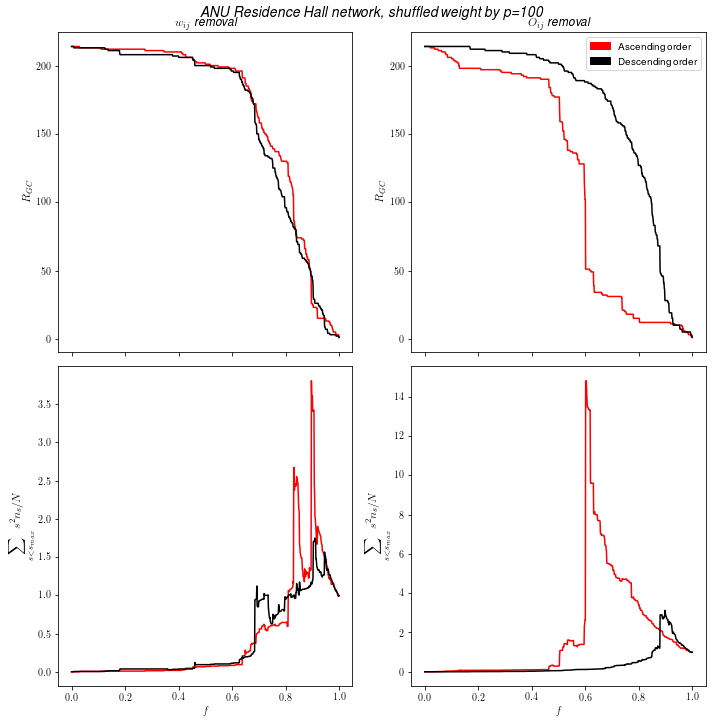

In [ ]:
visualise7(Gw7)

# Draft/ working

In [ ]:
w_dict = {}
for node1, node2, data in G.edges(data=True):
  edge = (node1,node2)
  w = data['weight']
  if w in w_dict:
    w_dict[w].append(edge)
  else:
    w_dict[w]= [edge]

In [ ]:
s_list = [len(c) for c in sorted(nx.connected_components(G), key=len)]
s_list.pop()

6

In [ ]:
dict(Counter(s_list))

{1: 214, 2: 46, 3: 15, 4: 1, 5: 3}

In [ ]:
a = {2: 4, 3: 2, 5: 1, 7: 1}
[key * val for key, val in a.items()]

[8, 6, 5, 7]

In [ ]:
a = {2: 4, 3: 2, 5: 1, 7: 1}
[key**2 * val for key, val in a.items()]

[16, 18, 25, 49]

In [ ]:
sum([key**2 * val for key, val in a.items()])

108

In [ ]:
nodes = pd.read_csv('/content/drive/MyDrive/1USyd/3rd_sem/DATA5441/assignments/DATA5441_project7/data/calls.csv/nodes_.csv')
coordinates = nodes[['index','_pos']]
print(coordinates)

     index                          _pos
0        0   (10.97326429, -14.08538066)
1        1   (11.682113  , -12.17420266)
2        2    (9.10239407, -13.51266005)
3        3   (12.81412555, -18.51461056)
4        4     (8.62673827, -9.58179487)
..     ...                           ...
531    531  (  3.05746548, -14.63400628)
532    532    (14.56131924, -7.19704119)
533    533  (  7.55651828, -18.8602933 )
534    534    ( 6.3042271 , -9.68271673)
535    535    (10.04203302, -8.44600162)

[536 rows x 2 columns]


In [ ]:
pos = dict(zip(coordinates.index, np.float(coordinates._pos)))

In [ ]:
coordinates._pos = pd.to_numeric(coordinates._pos, downcast="float")

In [ ]:
import collections

unsorted_dict = {3:[(7,8),(9,10)],1:[(1,2),(3,4),(5,6)],4:[(11,12),(13,14)]}
sorted_dict_ascending = dict(sorted(unsorted_dict.items()))
sorted_dict_descending = dict(sorted(unsorted_dict.items(),reverse=True))

In [ ]:
sorted_dict_ascending

{1: [(1, 2), (3, 4), (5, 6)], 3: [(7, 8), (9, 10)], 4: [(11, 12), (13, 14)]}

In [ ]:
sorted_dict_descending

{1: [(1, 2), (3, 4), (5, 6)], 3: [(7, 8), (9, 10)], 4: [(11, 12), (13, 14)]}

In [ ]:
for elem in sorted(unsorted_dict.items(), reverse=True) :
    print(elem[0] , " ::" , elem[1] )

4  :: [(11, 12), (13, 14)]
3  :: [(7, 8), (9, 10)]
1  :: [(1, 2), (3, 4), (5, 6)]


In [ ]:
sorted_k = sorted(unsorted_dict, reverse=True)

In [ ]:
sorted_list_descending = []
for k in sorted_k:
  for edge in unsorted_dict[k]:
    sorted_list_descending.append(edge)

In [ ]:
sorted_list_descending

[(11, 12), (13, 14), (7, 8), (9, 10), (1, 2), (3, 4), (5, 6)]

In [ ]:
def Convert(lst):
    res_dct = {lst[i]: lst[i + 1] for i in range(0, len(lst), 2)}
    return res_dct

In [ ]:
def Convert(a):
    it = iter(a)
    res_dct = dict(zip(it, it))
    return res_dct

In [ ]:
sorted_dict_descending = Convert(sorted(unsorted_dict.items(), reverse=True))

TypeError: ignored